tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        [-6.0262, -4.4375],
        [-3.3397,  7.2175],
        [ 0.7755,  7.8018],
        [-4.2962,  9.9991],
        [ 3.8225,  2.5719],
        [-7.6469,  5.4421],
        [-3.7474,  8.5322]]), tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0])


Text(0.5, 1.0, 'Testing Data')

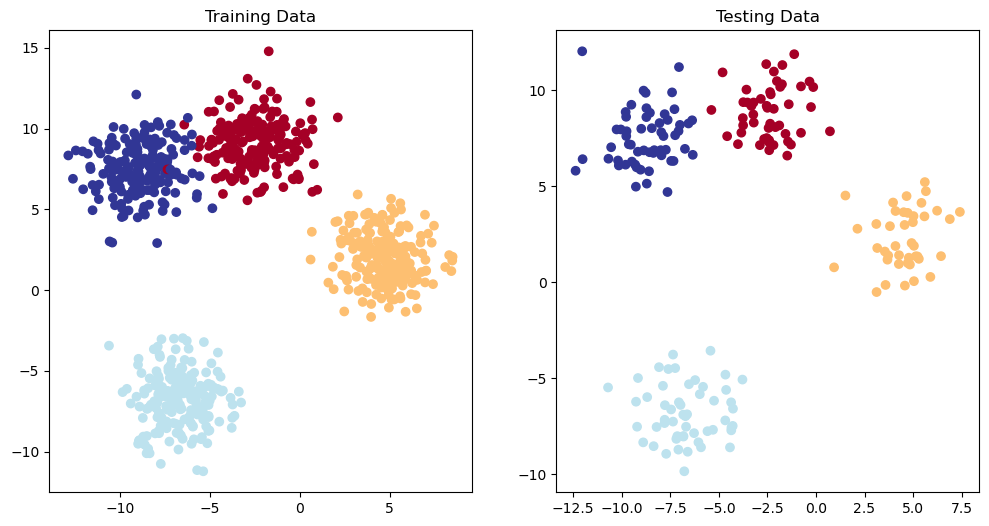

In [ ]:
#Now, from scratch, lets make a multi-class classification problem using the make_blobs() from sklearn,
#which creates however many classes we want, using the centers= parameter
#so, first we will turn the data into tensors, train test split, and visualize

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#Device agnostic code:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

    




num_samples = 1000
num_classes = 4
num_features = 2
random_seed = 42

X_blob,Y_blob = make_blobs(n_samples=num_samples,n_features=num_features,centers=num_classes,random_state=random_seed,cluster_std=1.5)

#currently, X_Blob is an ndarray of size (num_samples,num_features), and Y_Blob is also an ndarray of size (sum_samples,)
X_data = torch.from_numpy(X_blob).type(torch.float) #just because MPS cannot support float64
Y_labels = torch.from_numpy(Y_blob).type(torch.LongTensor)

#train-test-split:

X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_labels,test_size=0.2,random_state=random_seed)

#print out a sample of the data:
print(f"{X_train[:10]}, {Y_train[:10]}")

#plot the  data
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.RdYlBu)
plt.title("Training Data")
plt.subplot(1,2,2)
plt.scatter(X_test[:,0],X_test[:,1],c=Y_test,cmap=plt.cm.RdYlBu)
plt.title("Testing Data")






In [2]:
#Now, lets make the model:
from torch import nn

class MultiClassModel(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=8):

        """ 
        Initializes all required hypermarameters for a Mulit-Class Classification
        input_features = the number of features that each datapoint has, defined at the top
        output_features = the number of classes that objects can be grouped in
        hidden_units = the number of hidden neurons per layer, defaults to 8
        """

        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self,x):
        return self.linear_layer_stack(x)
model_4 = MultiClassModel(input_features=num_features,output_features=num_classes,hidden_units=8).to(device)
model_4


MultiClassModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [3]:
#Now, create the loss function and optimizer for the mutli-class model:

loss_fn = torch.nn.CrossEntropyLoss() #includes a softmax internally
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.01)

In [4]:
#what do our outputs look like:
model_4.eval()
with torch.inference_mode():
    Y_logit_preds = model_4(X_test.to(device))
print(Y_logit_preds[:5], Y_logit_preds[0].shape)

Y_preds = torch.softmax(Y_logit_preds,dim=1) #dim means across which dimension to compare
print(Y_preds[:5])
#here, each value represents the probability of it being each class

#But there is a very important thing about these numbers, which is that in each row, the sum total is 1!!!
print(Y_preds[0].sum())

#since there is one value for each class, the value which is the hightest is the one the model thinks it is

#which class does the model think it is:
print(Y_preds[0].argmax()) #returns 3, meaning that for the first object/features pair, the model is currently predicting that it is in class 3


tensor([[-0.8843,  0.5780,  0.5075, -0.3594],
        [ 0.2407, -0.1352, -0.4005, -0.1557],
        [ 0.7746, -0.5093, -0.4656, -0.2292],
        [-0.4830,  0.4762,  0.2944, -0.2615],
        [-0.6932,  0.4921,  0.4675, -0.4386]], device='mps:0') torch.Size([4])
tensor([[0.0907, 0.3914, 0.3647, 0.1533],
        [0.3465, 0.2379, 0.1825, 0.2331],
        [0.5174, 0.1433, 0.1497, 0.1896],
        [0.1422, 0.3710, 0.3094, 0.1774],
        [0.1142, 0.3738, 0.3647, 0.1474]], device='mps:0')
tensor(1., device='mps:0')
tensor(1, device='mps:0')


In [5]:
#first, lets get set up by creating a place to store the model results
from pathlib import Path 

MODEL_RESULTS = Path("Model_Results")
MODEL_RESULTS.mkdir(parents=True,exist_ok=True)

RESULTS_NAME = "model_4_exp1.csv" #THE FILE HEADER MUST BE IN THE NAME
RESULTS_PATH = MODEL_RESULTS / RESULTS_NAME



In [6]:
#code for importing the accuracy function
from pathlib import Path 
import requests

if Path("helper_functions.py").is_file():
    print(f"File 'helper_functions.py' already exists. Skipping download...")
else:
    request = requests.get(url="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    #now, the file is downloaded, but not written to disk, so fix that
    with open(file="helper_functions.py",mode="wb",newline="") as file:
        file.write(requests.content)

from helper_functions import accuracy_fn

File 'helper_functions.py' already exists. Skipping download...


In [7]:
#trian-test loop for a multi-class pytorch model: train for 1000 epochs and evaluate every 10.
import csv

torch.manual_seed(42)

#define the variables to read:
epochs = 1000
#THE TRAINING AND TESTING ACCURACY AND LOSS WILL BE STORED IN THE CSV

#NEXT, MOVE THE DATA TO THE MODEL:
X_train, X_test, Y_train, Y_test = (tensor.to(device).type(torch.float) for tensor in (X_train, X_test, Y_train, Y_test))

#Now that the data is ready, we can start the looping process:

with open(file=RESULTS_PATH,mode="w",newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch","Training Loss","Testing Loss", "Training Accuracy", "Testing Accuracy"])
    #now the loop:
    for epoch in range(epochs):

        #first, do a forwardpass on the data
        Y_logit_preds = model_4(X_train) #output in form (batch, 4)
        Y_preds = torch.softmax(Y_logit_preds,dim=1).argmax(dim=1) #argmax returns a tensor where everything is 0 but the argmax which is one
        #if no dim is specified, it flattens the tensor into a list and returns the index, but if a dimension is specified, it compares across that dimension
        #and returns an array with that dim flattened and replaced.(returns a tensor of size: (batch,) where each value is between 0 and 3)
        
        #next, calculate the loss function:
        loss = loss_fn(Y_logit_preds,Y_train) #this comes with a buildin softmax and argmax dw

        #now the accuracy(remmeber to import it):
        acc = accuracy_fn(y_true=Y_train,y_pred=Y_preds)

        #now we can zero the gradients and prepare for backprop:
        optimizer.zero_grad()

        #now, we backpropogate through the data
        loss.backward()

        #now that the gradietns are found, step the optimizer to lower loss
        optimizer.step()

        #now the testing loop(COMMAND + ] LETS YOU MASS INDENT OVER ONE TAB AND CMD + [ LETS YOU INDENT BACK ONE TAB)
        
        model_4.eval()
        with torch.inference_mode():
            #forward pass through the data
            Y_test_logits = model_4(X_test)
            Y_test_preds = torch.softmax(input=Y_test_logits,dim=1).argmax(dim=1)

            #now calculate the loss and accuracy
            test_loss = loss_fn(Y_test_logits,Y_test)
            test_acc = accuracy_fn(y_true=Y_test,y_pred=Y_test_preds)

            #now we write the data to the csv file:
            writer.writerow([epoch,loss.detach().cpu().numpy(),test_loss.detach().cpu().numpy(),acc,test_acc])

            #now we print out whats going on:
            if epoch % 10 == 0:
                print(f"Epoch: {epoch} | Training Loss: {loss.detach().cpu().numpy()} | Testing Loss: {test_loss.detach().cpu().numpy()} | Training Accuracy: {acc} | Testing Accuracy: ")
                    







Epoch: 0 | Training Loss: 1.4640861749649048 | Testing Loss: 1.472400188446045 | Training Accuracy: 33.375 | Testing Accuracy: 
Epoch: 10 | Training Loss: 1.255373239517212 | Testing Loss: 1.2627040147781372 | Training Accuracy: 51.0 | Testing Accuracy: 
Epoch: 20 | Training Loss: 1.1188764572143555 | Testing Loss: 1.1229424476623535 | Training Accuracy: 72.125 | Testing Accuracy: 
Epoch: 30 | Training Loss: 1.018764853477478 | Testing Loss: 1.0208213329315186 | Training Accuracy: 71.5 | Testing Accuracy: 
Epoch: 40 | Training Loss: 0.9426677823066711 | Testing Loss: 0.9448257684707642 | Training Accuracy: 70.125 | Testing Accuracy: 
Epoch: 50 | Training Loss: 0.8809249997138977 | Testing Loss: 0.8847095966339111 | Training Accuracy: 69.625 | Testing Accuracy: 
Epoch: 60 | Training Loss: 0.8278425335884094 | Testing Loss: 0.8341600298881531 | Training Accuracy: 70.375 | Testing Accuracy: 
Epoch: 70 | Training Loss: 0.7804129123687744 | Testing Loss: 0.7892383337020874 | Training Accura

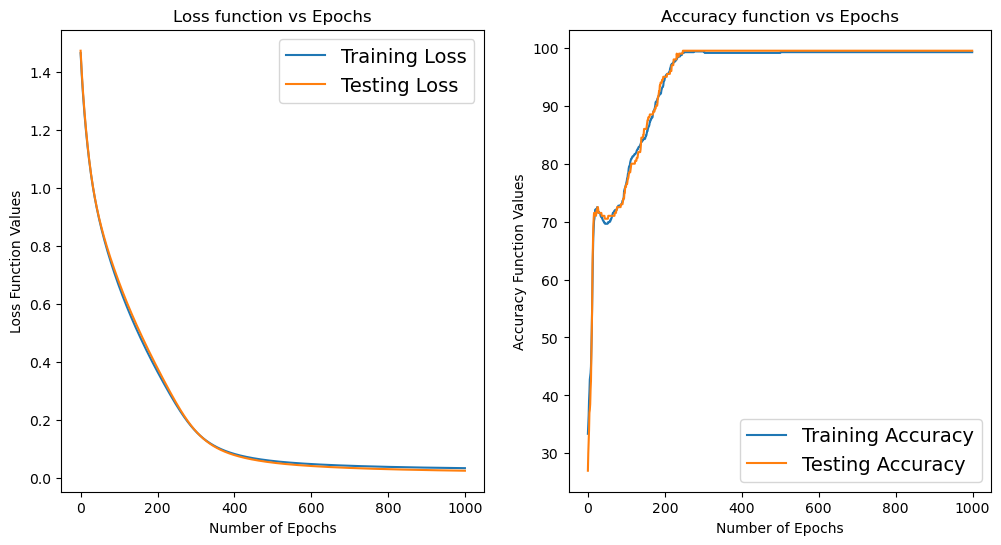

In [8]:
#now lets plot the results of our experiment:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path 

#first, create a place to save the file
PLOT_DIR = Path("plots")
PLOT_DIR.mkdir(parents=True,exist_ok=True)

PLOT_NAME = "model_4_exp1_plots.png"
PLOT_PATH = PLOT_DIR / PLOT_NAME

#Now lets read in the csv file as a pandas dataframe
df = pd.read_csv(filepath_or_buffer=RESULTS_PATH)

#now, we can begin to plot:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(df["Epoch"],df["Training Loss"],label="Training Loss")
plt.plot(df["Epoch"],df["Testing Loss"], label="Testing Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Function Values")
plt.title("Loss function vs Epochs")
plt.legend(prop={"size":14})

plt.subplot(1,2,2)
plt.plot(df["Epoch"],df["Training Accuracy"],label="Training Accuracy")
plt.plot(df["Epoch"],df["Testing Accuracy"], label="Testing Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy Function Values")
plt.title("Accuracy function vs Epochs")
plt.legend(prop={"size":14})

plt.savefig(PLOT_PATH)



In [9]:
''' 
TIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S") #this is to avoid overrides by saving the time

MODEL_PATH = MODEL_DIR / f"{MODEL_NAME}_{TIMESTAMP}.pt"
CSV_PATH = CSV_DIR / f"{MODEL_NAME}_{TIMESTAMP}.csv"
GRAPH_PATH = GRAPH_DIR / f"{MODEL_NAME}_{TIMESTAMP}.png"


csv_path = Path("results/exp1.csv")

# Change the suffix to .png
png_path = csv_path.with_suffix(".png")

can also use with the stem prefix to use just the stem:
base_name = csv_path.stem  # 'exp1'
new_path = Path("graphs") / f"{base_name}.png"



'''

' \nTIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S") #this is to avoid overrides by saving the time\n\nMODEL_PATH = MODEL_DIR / f"{MODEL_NAME}_{TIMESTAMP}.pt"\nCSV_PATH = CSV_DIR / f"{MODEL_NAME}_{TIMESTAMP}.csv"\nGRAPH_PATH = GRAPH_DIR / f"{MODEL_NAME}_{TIMESTAMP}.png"\n\n\ncsv_path = Path("results/exp1.csv")\n\n# Change the suffix to .png\npng_path = csv_path.with_suffix(".png")\n\ncan also use with the stem prefix to use just the stem:\nbase_name = csv_path.stem  # \'exp1\'\nnew_path = Path("graphs") / f"{base_name}.png"\n\n\n\n'

In [10]:
#now, lets run inference on our now trained model and see how it preforms, starting off with saving our model:
from pathlib import Path 

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(parents=True,exist_ok=True)

MODEL_NAME = "model_4"
MODEL_PATH = MODEL_DIR / MODEL_NAME

#now, we save the model:
torch.save(obj=model_4.state_dict(),f=MODEL_PATH)


In [11]:
#Now load it back for inference
model_4_loaded = MultiClassModel(input_features=num_features,output_features=num_classes,hidden_units=8).to(device)
model_4_loaded.load_state_dict(torch.load(f=MODEL_PATH,weights_only=True))

#now lets infer:
model_4_loaded.eval()
with torch.inference_mode():
    loaded_logit_preds = model_4_loaded(X_test)

loaded_preds = torch.softmax(input=loaded_logit_preds,dim=1).argmax(dim=1)
print(loaded_preds[:5])

tensor([1, 3, 2, 1, 0], device='mps:0')


In [12]:
#now, we can use the descision_boundary function to see how the model is doing, but first lets just get the gist

print(f"First 5 predicts: {loaded_preds[:5]}\nFirst 5 answers: {Y_test[:5]}")
print(f"Accuracy on the predictions: {accuracy_fn(y_true=Y_test,y_pred=loaded_preds)}")

First 5 predicts: tensor([1, 3, 2, 1, 0], device='mps:0')
First 5 answers: tensor([1., 3., 2., 1., 0.], device='mps:0')
Accuracy on the predictions: 99.5


Text(0.5, 1.0, 'Testing Descisions')

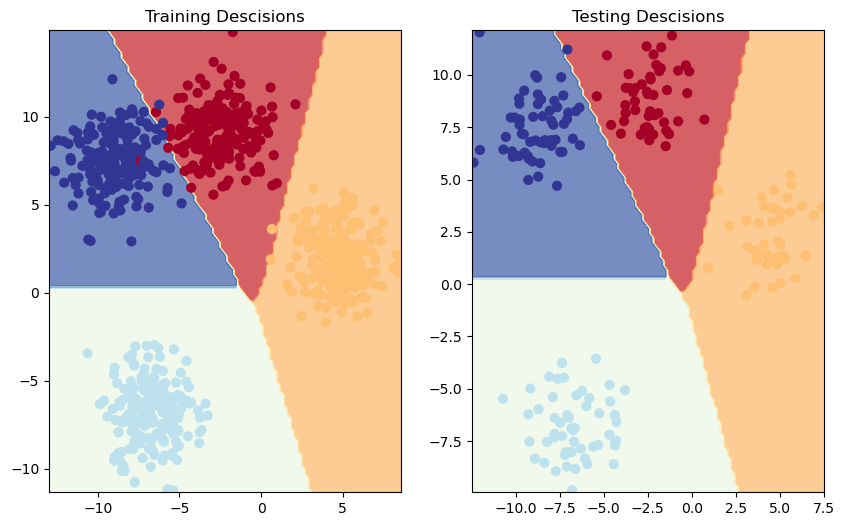

In [13]:
#now, lets plot to see how well we are doing
from helper_functions import plot_decision_boundary

#move the data back to the CPU:
X_train, X_test, Y_train, Y_test = (tensor.to("cpu").type(torch.float) for tensor in (X_train, X_test, Y_train, Y_test))

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("Training Descisions")
plot_decision_boundary(model_4_loaded,X_train,Y_train)

plt.subplot(1,2,2)
plot_decision_boundary(model_4_loaded,X_test,Y_test)
plt.title("Testing Descisions")



